# Open exploration
In this second tuturial, I will showcase how to use the ema_workbench for performing open exploration. This tuturial will continue with the same example as used in the previos tuturial.

## some background
In exploratory modeling, we are interested in understanding how regions in the uncertainty space and/or the decision space map to the whole outcome space, or partitions thereof. There are two general approaches for investigating this mapping. The first one is through systematic sampling of the uncertainty or decision space. This is sometimes also known as open exploration. The second one is to search through the space in a directed manner using some type of optimization approach. This is sometimes also known as directed search. 

The workbench support both open exploration and directed search. Both can be applied to investigate the mapping of the uncertainty space and/or the decision space to the outcome space. In most applications, search is used for finding promising mappings from the decision space to the outcome space, while exploration is used to stress test these mappings under a whole range of possible resolutions to the various uncertainties. This need not be the case however. Optimization can be used to discover the worst possible scenario, while sampling can be used to get insight into the sensitivity of outcomes to the various decision levers. 

## open exploration
To showcase the open exploration functionality, let's start with a basic example using the Direct Policy Search (DPS) version of the lake problem [(Quinn et al 2017)](https://doi.org/10.1016/j.envsoft.2017.02.017). This is the same model as we used in the general introduction. Note that for convenience, I have moved the code for the model to a module called dps_lake_model.py, which I import here for further use. 

We are going to simultaneously sample over uncertainties and decision levers. We are going to generate 1000 scenarios and 5 policies, and see how they jointly affect the outcomes. A *scenario* is understood as a point in the uncertainty space, while a *policy* is a point in the decision space. The combination of a scenario and a policy is called *experiment*. The uncertainty space is spanned by uncertainties, while the decision space is spanned by levers. 

Both uncertainties and levers are instances of *RealParameter* (a continuous range), *IntegerParameter* (a range of integers), or *CategoricalParameter* (an unorder set of things). By default, the workbench will use Latin Hypercube sampling for generating both the scenarios and the policies. Each policy will be always evaluated over all scenarios (i.e. a full factorial over scenarios and policies). 


In [1]:
from ema_workbench import (RealParameter, ScalarOutcome, Constant, 
                           Model)
from dps_lake_model import lake_model

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

model = Model('lakeproblem', function=lake_model)

#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]

# set levers
model.levers = [RealParameter("c1", -2, 2),
                RealParameter("c2", -2, 2),
                RealParameter("r1", 0, 2), 
                RealParameter("r2", 0, 2), 
                RealParameter("w1", 0, 1)]

#specify outcomes 
model.outcomes = [ScalarOutcome('max_P'),
                  ScalarOutcome('utility'),
                  ScalarOutcome('inertia'),
                  ScalarOutcome('reliability')]

# override some of the defaults of the model
model.constants = [Constant('alpha', 0.41),
                   Constant('nsamples', 150),
                   Constant('myears', 100)]

In [2]:
from ema_workbench import (MultiprocessingEvaluator, ema_logging, 
                           perform_experiments)
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model, n_processes=7) as evaluator:
    results = evaluator.perform_experiments(scenarios=1000, policies=5)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 5 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


### Visual analysis
Having generated these results, the next step is to analyze them and see what we can learn from the results. The workbench comes with a variety of techniques for this analysis. A simple first step is to make a few quick visualizations of the results. The workbench has convenience functions for this, but it also possible to create your own visualizations using the scientific Python stack. 


[MainProcess/INFO] no time dimension found in results


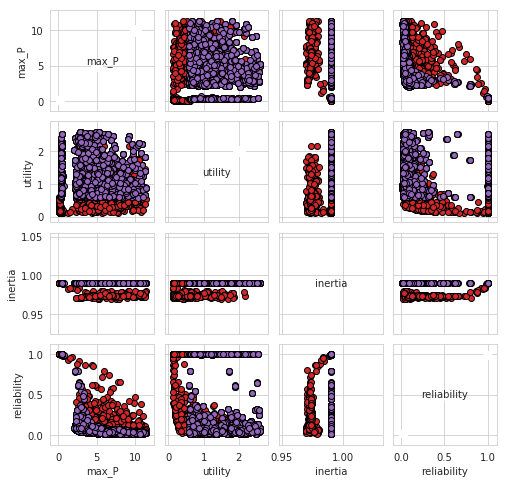

In [3]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(results, group_by='policy', 
                                         legend=False)
fig.set_size_inches(8,8)
plt.show()

Often, it is convenient to separate the process of performing the experiments from the analysis. To make this possible, the workbench offers convenience functions for storing results to disc and loading them from disc. The workbench will store the results in a tarbal with .csv files and separate metadata files. This is a convenient format that has proven sufficient over the years. 

```python
from ema_workbench import save_results
save_results(results, '1000 scenarios 5 policies.tar.gz')

from ema_workbench import load_results
results = load_results('1000 scenarios 5 policies.tar.gz')
```

## advanced analysis
In addition to visual analysis, the workbench comes with a variety of techniques to perform a more in-depth analysis of the results. In addition, other analyses can simply be performed by utilizing the scientific python stack. The workbench comes with

* [Scenario Discovery](https://waterprogramming.wordpress.com/2015/08/05/scenario-discovery-in-python/), a model driven approach to scenario development
* Feature Scoring, a poor man's alternative to global sensitivity analysis
* Dimensional stacking, a quick visual approach drawing on feature scoring to enable scenario discovery. This approach has received limited attention in the literature [(Suzuki et al., 2015)](https://www.onepetro.org/conference-paper/SPE-174774-MS). The implementation in the workbench replaces the rule mining approach with a feature scoring approach. 
* Regional sensitivity analysis

### Scenario Discovery
A detailed discussion on scenario discovery can be found in an [earlier blogpost](https://waterprogramming.wordpress.com/2015/08/05/scenario-discovery-in-python/). For completeness, I provide a code snippet here. Compared to the previous blog post, there is one small change. The library mpld3 is currently not being maintained and broken on Python 3.5. and higher. To still utilize the interactive exploration of the trade offs within the notebook, one could use the interactive back-end [(% matplotlib notebook)](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-matplotlib). 

In [4]:
from ema_workbench.analysis import prim

experiments, outcomes = results

x = experiments
y = outcomes['max_P'] <0.8
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] 5000 points remaining, containing 1044 cases of interest


KeyboardInterrupt: 

In [ ]:
box1.show_tradeoff()
plt.show()

We can inspect any of the points on the trade off curve using the inspect method. As shown, we can show the results either in a table format or in a visual format.

coverage    0.766355
density     0.803922
mass           0.102
mean        0.803922
res dim            3
Name: 43, dtype: object

        box 43                                     
           min       max                  qp values
b     0.375679  0.449991  [1.5801880457941885e-155]
q     3.393327  4.499832   [2.9676799270947978e-68]
mean  0.010036  0.047837      [0.05776223847296219]



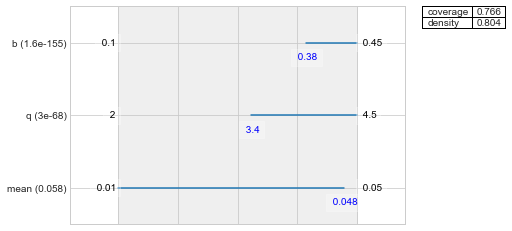

In [7]:
box1.inspect(43)
box1.inspect(43, style='graph')
plt.show()

### feature scoring
Feature scoring is a family of techniques often used in machine learning to identify the most relevant features to include in a model. This is similar to one of the use cases for global sensitivity analysis, namely factor prioritisation. The main advantage of feature scoring techniques is that they impose no specific constraints on the experimental design, while they can handle real valued, integer valued, and categorical valued parameters. The workbench supports multiple techniques, the most useful of which generally is extra trees [(Geurts et al. 2006)](https://link.springer.com/article/10.1007/s10994-006-6226-1). 

For this example, we run feature scoring for each outcome of interest. We can also run it for a specific outcome if desired. Similarly, we can choose if we want to run in regression mode or classification mode. The later is applicable if the outcome is a categorical variable and the results should be interpreted similar to regional sensitivity analysis results. For more details, see the documentation.

/Users/jhkwakkel/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/jhkwakkel/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


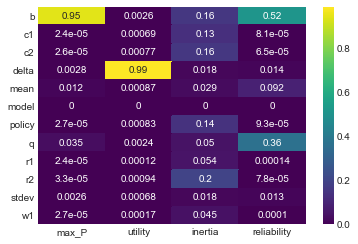

In [8]:
from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

From the results, we see that max_P is primarily influenced by b, while utility is driven by delta, for inertia and reliability the situation is a little bit less clear cut. 

### dimensional stacking
Dimensional stacking was suggested as a more visual approach to scenario discovery. It involves two steps: identifying the most important uncertainties that affect system behavior, and creating a pivot table using the most influential uncertainties. In order to do this, we first need, as in scenario discovery, specify the outcomes that are of interest. The creating of the pivot table involves binning the uncertainties. More details can be found in [Suzuki et al. (2015)](https://www.onepetro.org/conference-paper/SPE-174774-MS) or by looking through the code in the workbench. Compared to Suzuki et al, the workbench uses feature scoring for determining the most influential uncertainties. The code is set up in a modular way so other approaches to global sensitivity analysis can easily be used as well if so desired. 


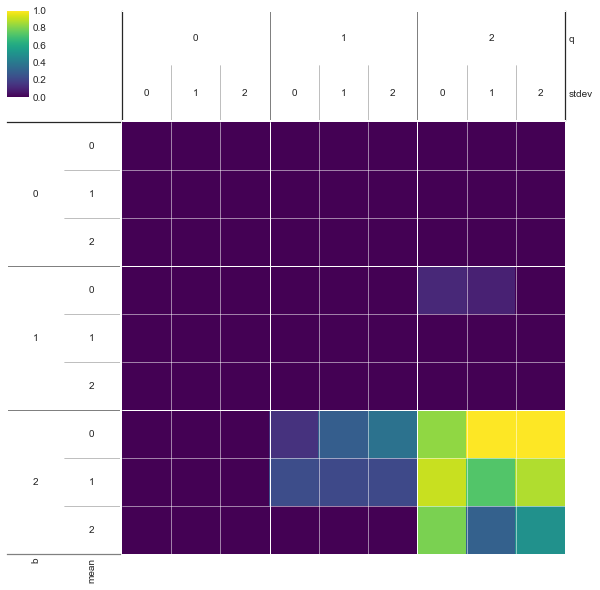

In [9]:
from ema_workbench.analysis import dimensional_stacking

x = experiments
y = outcomes['max_P'] <0.8
dimensional_stacking.create_pivot_plot(x,y, 2, nbins=3)
plt.show()


We can see from this visual that if B is high, while Q is low, we have a high concentration of cases where pollution stays below 0.8. The mean and stdev have some limited additional influence. By playing around with an alternative number of bins, or different number of layers, patterns can be coarsened or refined. 

### regional sensitivity analysis

A fourth approach for supporting scenario discovery is to perform a regional sensitivity analysis. The workbench implements a visual approach based on plotting the empirical CDF given a classification vector. Please look at section 3.4 in [Pianosi et al (2016)](http://www.sciencedirect.com/science/article/pii/S1364815216300287#sec3.4) for more details.

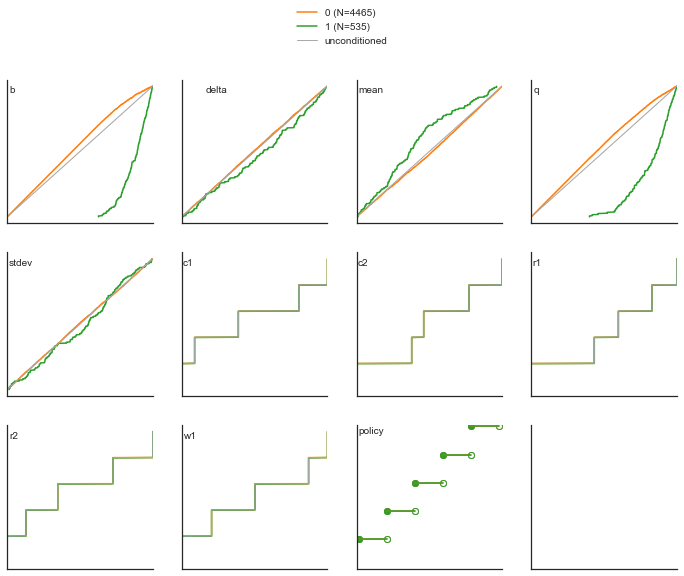

In [10]:
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

sns.set_style('white')

# model is the same across experiments
x = rf.drop_fields(experiments, 'model', asrecarray=True)
y = outcomes['max_P'] < 0.8
fig = regional_sa.plot_cdfs(x,y)
sns.despine()
plt.show()

The above results clearly show that both B and Q are important. to a lesser extend, the mean also is relevant.

## More advanced sampling techniques

The workbench can also be used for more advanced sampling techniques. To achieve this, it relies on [SALib](http://salib.readthedocs.io/en/latest/). On the workbench side, the only change is to specify the sampler we want to use. Next, we can use SALib directly to perform the analysis. To help with this, the workbench provides a convenience function for generating the problem dict which SALib provides. The example below focusses on performing SOBOL on the uncertainties, but we could do the exact same thing with the levers instead. The only changes required would be to set `lever_sampling` instead of `uncertainty_sampling`, and get the SALib problem dict based on the levers.


In [11]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, 
                                               uncertainty_sampling='sobol')
    
experiments, outcomes = sa_results

problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(problem, outcomes['max_P'], 
                   calc_second_order=True, print_to_console=False)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 1 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


We have now completed the sobol analysis and have calculated the metrics. What remains is to visualize the metrics. Which can be done as shown below, focussing on St and S1. The error bars indicate the confidence intervals. 

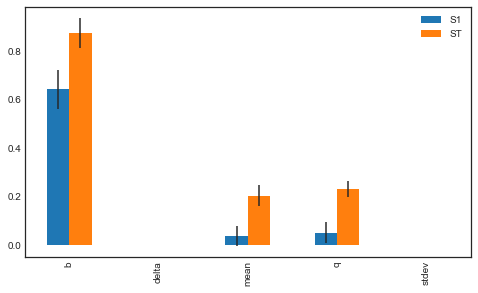

In [12]:
scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()